## PCoA of Enzymatic Activities in cMWS

Our goal in this notebook is to calculate distances between the immune enzyme activity profile for each pair of samples, and visualize with a PCoA.

**Requires the environment have scikit-bio available (typically by running in a QIIME2 conda environment)


#### Step 0. Import necessary libraries, & check that the data file exists

In [2]:
import skbio as skibio
from os.path import exists
import pandas as pd
import numpy as np
from scipy.spatial import distance
from IPython.core.display import HTML,display

#Input files needed
enzyme_data_filepath = 'protein_MWS.tsv'
enzyme_metadata_filepath = 'enzyme_metadata.tsv'

#Output files that will be created
results_file = "enzyme_distance_matrix.tsv"

required_files = [enzyme_data_filepath,enzyme_metadata_filepath]
for f in required_files:
    if not exists(f):
        raise ValueError(f"Required file {f} is missing")
print("All required files found.")

All required files found.


#### Step 1. Load the data as a pandas DataFrame

We're going to load our .tsv file and set the index column to be 'Samples'. 

In [3]:

enzyme_data = pd.read_csv(enzyme_data_filepath,sep="\t")
enzyme_data = enzyme_data.set_index("Samples")
enzyme_data


,Tyrosine,Dopamine,L DOPA,Methylcatechol,Hydroquinone
Samples,,,,,
WS 1,0.040667,0.033719,0.179500,0.036167,0.013000
WS 2,0.010333,0.052630,0.169667,0.033000,0.014000
WS 3,0.013333,0.048500,0.143500,0.040667,0.017667
WS 4,0.021667,0.063888,0.162667,0.034000,0.013667
WS 5,0.055333,0.074812,0.167333,0.037000,0.018000
WSH 1,0.277667,0.115869,0.352500,0.033500,0.021667
WSH 2,0.229000,0.158892,0.374333,0.042667,0.012333
WSH 3,0.031667,0.195486,0.322667,0.042000,0.019667
WSH 4,0.158500,0.091503,0.199000,0.037500,0.023333


#### Mean normalize the data

Since different enzymes (e.g. L-DOPA) have varying overall levels, we mean normalized the data to allow each variable to equally influence the PCoA

In [4]:
enzyme_data =(enzyme_data-enzyme_data.mean())/enzyme_data.std()
enzyme_data.style.background_gradient(cmap="Greens")

,Tyrosine,Dopamine,L DOPA,Methylcatechol,Hydroquinone
Samples,,,,,
WS 1,-0.713174,-0.97841,-0.832019,-0.157465,-0.343633
WS 2,-0.91533,-0.570198,-0.913589,-0.676881,-0.137453
WS 3,-0.895336,-0.659357,-1.13065,0.580652,0.618539
WS 4,-0.839799,-0.327194,-0.971656,-0.512855,-0.20618
WS 5,-0.615428,-0.0913781,-0.932945,-0.0207766,0.687266
WSH 1,0.866309,0.794874,0.603068,-0.594868,1.44326
WSH 2,0.541971,1.72356,0.784182,0.908704,-0.481086
WSH 3,-0.773154,2.51347,0.355592,0.799354,1.0309
WSH 4,0.0721245,0.268898,-0.67026,0.0612364,1.78689


#### Set up results array

We'll have one resulting distance per pair of samples
regardless of the number of enzyme activities measured,
so the number of samples will be the number of rows and columns

In [5]:
n_samples,n_enzyme_activites = enzyme_data.shape


results_array = np.full([n_samples,n_samples],np.NaN)
print(results_array)

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]


#### Set up a function to show arrays as pretty HTML tables



In [6]:
def pretty_table_from_array(data_array, row_labels,col_labels):
    """Show an HTML table from a 2d numpy array"""
    df = pd.DataFrame(data_array,index=row_labels,columns=col_labels)
    table_html = df.to_html()
    return HTML(table_html)

Let's try this out on our empty results array:

In [7]:
row_labels = list(enzyme_data.index)
col_labels = list(enzyme_data.index)
print(row_labels)
display(pretty_table_from_array(results_array,row_labels,col_labels))

['WS 1', 'WS 2', 'WS 3', 'WS 4', 'WS 5', 'WSH 1', 'WSH 2', 'WSH 3', 'WSH 4', 'WSH 5', 'HT 1', 'HT 2', 'HT 3', 'HT 4', 'HT 5']


,WS 1,WS 2,WS 3,WS 4,WS 5,WSH 1,WSH 2,WSH 3,WSH 4,WSH 5,HT 1,HT 2,HT 3,HT 4,HT 5
WS 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WS 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WS 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WS 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WS 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WSH 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WSH 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WSH 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WSH 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WSH 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Set up nested for loops to grab pairs of samples

We want to both track numerical i,j values for which samples we're comparing, and the actual sample ids and data for each sample. We use enumerate called on the DataFrame's iterrows method to get this:

`for i,(id1,data1) in enumerate(enzyme_data.iterrows()):`

It looks a little funky, but enumerate is returning the count of which sample we're on, followed by the results of iterrows (the sample id and data as a tuple).

In [8]:

for i,(id1,data1) in enumerate(enzyme_data.iterrows()):
    data1 = np.array(data1)
    for j,(id2,data2) in enumerate(enzyme_data.iterrows()):
        data2 = np.array(data2)
        current_dist = distance.euclidean(data1,data2)
        #set the results matrix at row i and column j to our
        #current distance
        results_array[i,j] = current_dist
        
display(pretty_table_from_array(results_array,row_labels,\
  col_labels))


,WS 1,WS 2,WS 3,WS 4,WS 5,WSH 1,WSH 2,WSH 3,WSH 4,WSH 5,HT 1,HT 2,HT 3,HT 4,HT 5
WS 1,0.000000,0.725576,1.301826,0.777695,1.374046,3.329126,3.555807,4.051183,2.604919,1.806895,4.665060,3.420526,3.609823,1.595992,0.755861
WS 2,0.725576,0.000000,1.486061,0.315841,1.195917,3.137401,3.591609,3.832018,2.446687,1.584415,5.020956,3.735536,3.417191,2.086308,1.317964
WS 3,1.301826,1.486061,0.000000,1.419371,0.898040,3.207174,3.567568,3.536743,1.909041,1.997699,5.048571,3.949473,4.532255,1.854001,1.889670
WS 4,0.777695,0.315841,1.419371,0.000000,1.071371,3.062184,3.360694,3.617687,2.362136,1.575150,4.920388,3.620269,3.532091,1.932366,1.310151
WS 5,1.374046,1.195917,0.898040,1.071371,0.000000,2.498285,3.132266,3.043212,1.373839,1.337959,4.849248,3.838981,3.969408,1.942650,1.976609
WSH 1,3.329126,3.137401,3.207174,3.062184,2.498285,0.000000,2.638995,2.795810,1.754224,1.691242,3.966744,3.910025,3.367814,3.104139,3.632173
WSH 2,3.555807,3.591609,3.567568,3.360694,3.132266,2.638995,0.000000,2.198921,3.211563,2.779399,3.301562,2.338318,4.440401,2.473757,3.553626
WSH 3,4.051183,3.832018,3.536743,3.617687,3.043212,2.795810,2.198921,0.000000,2.814484,3.014308,5.273618,4.080407,5.363728,3.567223,4.425337
WSH 4,2.604919,2.446687,1.909041,2.362136,1.373839,1.754224,3.211563,2.814484,0.000000,1.682601,4.809764,4.399005,4.276019,2.710728,3.115694
WSH 5,1.806895,1.584415,1.997699,1.575150,1.337959,1.691242,2.779399,3.014308,1.682601,0.000000,4.245205,3.299865,2.893913,2.126478,2.238326


#### Save the result to a file

Now that we have a distance matrix, we should cache it in a file for future reference and supplementary data.

In [9]:
df = pd.DataFrame(results_array,index=row_labels,\
    columns=col_labels)
df.to_csv(results_file,sep="\t")

In [10]:
#### Plot distance matrix as heatmap
%matplotlib inline
df.style.background_gradient(cmap="Greens")

,WS 1,WS 2,WS 3,WS 4,WS 5,WSH 1,WSH 2,WSH 3,WSH 4,WSH 5,HT 1,HT 2,HT 3,HT 4,HT 5
WS 1,0,0.725576,1.30183,0.777695,1.37405,3.32913,3.55581,4.05118,2.60492,1.8069,4.66506,3.42053,3.60982,1.59599,0.755861
WS 2,0.725576,0,1.48606,0.315841,1.19592,3.1374,3.59161,3.83202,2.44669,1.58442,5.02096,3.73554,3.41719,2.08631,1.31796
WS 3,1.30183,1.48606,0,1.41937,0.89804,3.20717,3.56757,3.53674,1.90904,1.9977,5.04857,3.94947,4.53225,1.854,1.88967
WS 4,0.777695,0.315841,1.41937,0,1.07137,3.06218,3.36069,3.61769,2.36214,1.57515,4.92039,3.62027,3.53209,1.93237,1.31015
WS 5,1.37405,1.19592,0.89804,1.07137,0,2.49829,3.13227,3.04321,1.37384,1.33796,4.84925,3.83898,3.96941,1.94265,1.97661
WSH 1,3.32913,3.1374,3.20717,3.06218,2.49829,0,2.639,2.79581,1.75422,1.69124,3.96674,3.91003,3.36781,3.10414,3.63217
WSH 2,3.55581,3.59161,3.56757,3.36069,3.13227,2.639,0,2.19892,3.21156,2.7794,3.30156,2.33832,4.4404,2.47376,3.55363
WSH 3,4.05118,3.83202,3.53674,3.61769,3.04321,2.79581,2.19892,0,2.81448,3.01431,5.27362,4.08041,5.36373,3.56722,4.42534
WSH 4,2.60492,2.44669,1.90904,2.36214,1.37384,1.75422,3.21156,2.81448,0,1.6826,4.80976,4.399,4.27602,2.71073,3.11569
WSH 5,1.8069,1.58442,1.9977,1.57515,1.33796,1.69124,2.7794,3.01431,1.6826,0,4.24521,3.29986,2.89391,2.12648,2.23833


#### Principle Coordinates Analysis

Now we need to make a PCoA visualization of our results. First we will convert our dataframe into an skbio DistanceMatrix object. We will need to fuss with the `'ids'`property to set it to our Samples column, then we can run the `skbio pcoa` function to get our ordination.

In [11]:
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix

dm = DistanceMatrix(df)

#For reasons unclear to me skbio DistanceMatrix was dropping SampleIDs
#we re-add them manually by setting the 'ids' properties
dm.ids = tuple(row_labels)
enzyme_pcoa = pcoa(dm)


#### Plotting the ordination

Now we will plot our ordination.

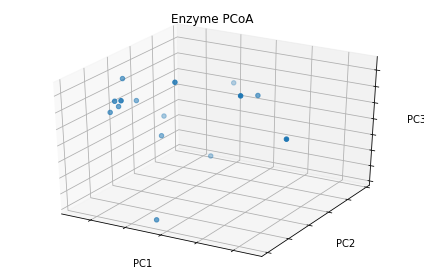

In [12]:
_ = enzyme_pcoa.plot(None, None, cmap='Greens', title="Enzyme PCoA", axis_labels=('PC1', 'PC2', 'PC3'))

As expected, our PCA is pretty boring without any metadata. Let's add that in.

In [13]:
enzyme_metadata = pd.read_csv(enzyme_metadata_filepath,sep="\t")
enzyme_metadata = enzyme_metadata.set_index('Sample')

#Show our metadata
enzyme_metadata


,HealthState
Sample,
WS 1,cMWS
WS 2,cMWS
WS 3,cMWS
WS 4,cMWS
WS 5,cMWS
WSH 1,Healthy Tissue of cMWS Colony
WSH 2,Healthy Tissue of cMWS Colony
WSH 3,Healthy Tissue of cMWS Colony
WSH 4,Healthy Tissue of cMWS Colony


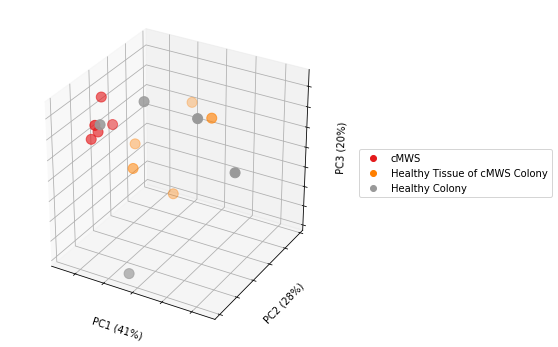

In [21]:
from matplotlib import colors

category_colors = {'cMWS': 'red', 'Healthy Tissue of cMWS Colony':'purple', 'Healthy Colony':'blue'}
c = [colors.to_rgba(category_colors[enzyme_metadata['HealthState'][sample_id]]) for sample_id in dm.ids]

portion_explained = enzyme_pcoa.proportion_explained

PC1_explained = int(round(portion_explained['PC1'],2)*100)
PC2_explained = int(round(portion_explained['PC2'],2)*100)
PC3_explained = int(round(portion_explained['PC3'],2)*100)

pcoa_fig = enzyme_pcoa.plot(enzyme_metadata,'HealthState', title=None, \
  axis_labels=(f'PC1 ({PC1_explained}%)', \
               f'PC2 ({PC2_explained}%)', \
               f'PC3 ({PC3_explained}%)'),\
   s=100,cmap='Set1')

pcoa_fig.set_figwidth(10)
pcoa_fig.set_figheight(5)

pcoa_fig.savefig('enzyme_pcoa.png',dpi=300)
pcoa_fig.savefig('enzyme_pcoa.svg')

pcoa_data = enzyme_pcoa.samples





#### Print additional PCoA details



In [22]:
print("PCoA data:\n",pcoa_data)
print("Portion explained:\n",portion_explained)

PCoA data:
             PC1       PC2       PC3       PC4       PC5  PC6  PC7  PC8  PC9  \
WS 1  -1.047092 -0.951471  0.545740  0.003365  0.038642  0.0  0.0  0.0  0.0   
WS 2  -1.342749 -0.721947  0.066681  0.350903 -0.151321  0.0 -0.0  0.0 -0.0   
WS 3  -1.485818  0.080490  0.790472 -0.551908  0.301519 -0.0  0.0  0.0  0.0   
WS 4  -1.230123 -0.519999  0.196916  0.368985 -0.321615 -0.0  0.0 -0.0 -0.0   
WS 5  -1.250667  0.297520  0.088026 -0.259086 -0.051898 -0.0 -0.0 -0.0  0.0   
WSH 1  0.380067  1.076418 -1.610396 -0.528702  0.082731  0.0  0.0 -0.0  0.0   
WSH 2  1.519799  1.384251  0.407160  0.556674 -0.484692  0.0  0.0  0.0 -0.0   
WSH 3  0.006147  2.822778  0.011624  0.880179 -0.022472 -0.0 -0.0  0.0  0.0   
WSH 4 -0.995276  1.128671 -0.639934 -1.019511  0.100500  0.0 -0.0  0.0 -0.0   
WSH 5 -0.406797  0.069785 -0.753264  0.109810  0.375071  0.0  0.0  0.0  0.0   
HT 1   3.409741 -0.583713  0.181213 -1.258939 -0.155990 -0.0  0.0  0.0 -0.0   
HT 2   2.096827 -0.440588  1.142781  0.9